# Homework 1-1

Here we will attempt to reproduce the graph presented in
https://aatishb.com/covidtrends/.

We will only consider US and China cases.

## Download the CSV files

In [1]:
url_confirmed = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
url_deaths = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
url_recovered = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv";

#download(url_confirmed, "covid_confirmed.csv")
#download(url_deaths, "covid_deaths.csv")
#download(url_recovered, "covid_recovered.csv");

In [2]:
using CSV
using Plots
using Dates
using Interact
using DataFrames

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-3868013131876948536\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-3640821349342174561\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-3868013131876948536\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

In [3]:
data = CSV.read("covid_confirmed.csv")
rename!(data, 1=>"Province", 2=>"Country")

# Parse dates
date_strings = String.(names(data))[5:end]
format = Dates.DateFormat("m/d/Y")
dates = parse.(Date, date_strings, format)+Year(2000);

┌ Warning: `CSV.read(input; kw...)` is deprecated in favor of `DataFrame!(CSV.File(input; kw...))`
└ @ CSV /Users/yanxon/.julia/packages/CSV/OM6FO/src/CSV.jl:40


In [4]:
# The case for doubling

function doubling(rate; limit=2e7)
    # cumulative total cases, daily new cases, cumulative cases per week
    total, daily, weekly = Any[], Any[], Any[]
    p0, p = 2^-5, 1
    push!(total, p0)
    
    count = 1
    while p < limit
        p = p0 * exp(log(2)*count/rate)
        if p < limit
            push!(total, p)
        end

        if count > 1
            push!(daily, total[count]-total[count-1])
        elseif count == 1
            push!(daily, total[count])
        end
        
        count += 1
    end
                
    for i in 7:length(daily)
        push!(weekly, sum(daily[i-6:i]))
    end
        
    return total, weekly
end

total, weekly = doubling(1);

In [5]:
countries = data[1:end, 2]
unique_countries = unique(countries)

data_china = data[findall(countries.=="China"), :]
data_us = data[findall(countries.=="US"), :]

data_china = sum(convert(Array, data_china[:, 5:end]), dims=1)
data_us = sum(convert(Array, data_us[:, 5:end]), dims=1);

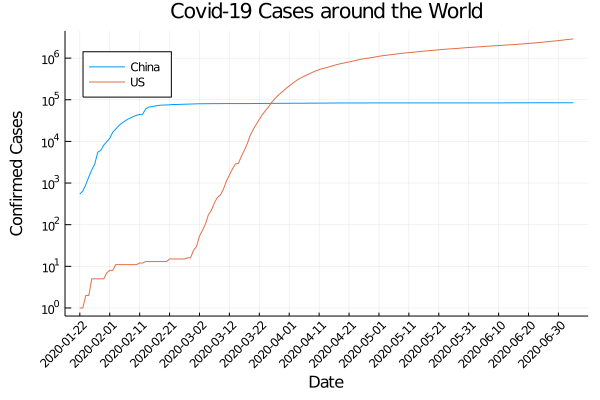

In [6]:
plot(dates, data_china[1,:], xticks=dates[1:10:end], xrotation=45, leg=:topleft, label="China", yscale=:log10)
plot!(dates, data_us[1,:], label="US")
xlabel!("Date")
ylabel!("Confirmed Cases")
title!("Covid-19 Cases around the World")

In [7]:
eps = 0

data_china_daily = zeros(size(data_china))[1, 2:end]
for i in 2:length(dates)
    data_china_daily[i-1] += data_china[:,i][1] - data_china[:,i-1][1] + eps
end

data_china_weekly = zeros(size(data_china))[:, 8:end]
for i in 7:length(data_china_daily)
    data_china_weekly[i-6] += sum(data_china_daily[i-6:i]) + eps
end

data_us_daily = zeros(size(data_us))[1, 2:end]
for i in 2:length(dates)
    data_us_daily[i-1] += data_us[:,i][1] - data_us[:,i-1][1] + eps
end

data_us_weekly = zeros(size(data_us))[:, 8:end]
for i in 7:length(data_us_daily)
    data_us_weekly[i-6] += sum(data_us_daily[i-6:i]) + eps
end

In [8]:
@manipulate for i in 1:length(dates)
    count = i
    plot(total[8:end], weekly[2:end], linestyle=:dash, leg=:topleft, 
        xscale=:log10, yscale=:log10, 
        label="Cases double everyday", 
        xlim=(10, 1e7), ylim=(10, 1e7), size=(900, 600))
    plot!(data_china[8:count+7], data_china_weekly[1:count], label="China")
    plot!(data_us[8:count+7], data_us_weekly[1:count], label="US")
    xlabel!("Total Confirmed Cases")
    ylabel!("Weekly Confirmed Cases")
    title!("Trajectory of World COVID-19 Confirmed Cases")
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["i"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 166,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Int64} with 2 listeners. Value:
83, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "/Users/yanxon/.julia/packages/Knockout/IP1uR/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/yanxon/.julia/packages/Knockout/IP1uR/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/yanxon/.julia/packages/InteractBase/sOe2Z/src/../assets/all.js"), Asset("css", nothing, "/Users/yanxon/.julia/packages/InteractBase/sOe2Z/src/../assets/style.css"), Asset("css", nothing, "/Users/yanxon/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(AbstractConnection[]), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x000000011930c250, Task (runnable) @0x000000011930c250), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\",\"25\",\"26\",\"27\",\"28\",\"29\",\"30\",\"31\",\"32\",\"33\",\"34\",\"35\",\"36\"